# Entrenamiento de modelos de aprendizaje con el dataset Polyvore

**Autor:** Roberto Araya Day

**Fecha de inicio:** 16/11/2022

## 1. Preparación de datos

- El archivo *type_aware_polyvore_outfits.py* es el script de **Learning Type Aware Embeddings for Fashion Compatibility** para cargar el dataset de Polyvore y crear ejemplos. Se define un **TripletImageLoader** con una serie de transformaciones para las imágenes. Este archivo retorna *Triplets* de imágenes postivas y negativas. Modificamos este archivo en la forma de **DoubletImageLoader** para retornar pares de imágenes. Revisar el archivo. 
- El archivo *similarity_conditions_triplet_image_loader.py* es el script de **Learning similarity Conditions** para cargar triplets de datos de Polyvore. Revisar.

- Se dividen en los archivos:
    - ***fashion_compatibility_prediction.txt***: En ***fashion_compatibility_prediction_val.txt*** y ***fashion_compatibility_prediction_test.txt*** para las métricas de validación y testeo. Puesto que el archivo contiene **7076** columnas, se ponen **3538** ejemplos en cada archivo.
    - ***fill_in_blank_test.txt***.
---

Los modelos de recomendación están conformados por la siguiente estructura:
1. **DoubletImageLoader**: Carga las imágenes, con sus metadatos, y se crean los ejemplos de pares de prendas positivos. Es decir, prendas compatibles. Esta basado en los dataloader de ambas investigaciones señaladas anteriormente.
    - Un DataLoader es una estructura que combina un dataset y un sampler, y provee un iterador sobre el dataset.


2. **DoubletNet**: Genera los embeddings y calcula la pérdida y distancia entre los vectores obtenidos de los ejemplos positivos. No se necesita para este caso, puesto que el **Modelo General** lo hace por si solo. No necesita obtener el loss o accuracy de los pares de imágenes.


3. **Modelo General**: Variante del modelo BYOL que recibe dos imágenes de entrada.

In [4]:
import sys
import os

sys.path
sys.path.append('/home/raraya/miniconda3/envs/fashion_model/lib/python3.10/site-packages')

In [5]:
# path to important folders
polyvore_dataset = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'polyvore_data')
polyvore_images = os.path.join(polyvore_dataset, 'images')
polyvore_info = os.path.join(polyvore_dataset, 'polyvore-info')

polyvore_train = os.path.join(polyvore_info, 'train_no_dup')
polyvore_val = os.path.join(polyvore_info, 'valid_no_dup')
polyvore_test = os.path.join(polyvore_info, 'test_no_dup')

## 2. Instalación de los modelos de aprendizaje
### 2.1 Instalación del modelo BYOL

   Se instala la variante del modelo BYOL del trabajo de *Javier Morales Rodriguez* del repositorio *bimodal-byol-shoes*:
- https://github.com/javier-op/bimodal-byol-shoes.

In [9]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%reload_ext autoreload

In [11]:
%autoreload 2

## 3. Entrenamiento y resultados en las métricas de evaluación

Se entrenan los modelos definidos en la sección anterior, usando el *DataLoader* para cargar los datos. 

**IMPORTANTE**: *SelectFromTuple* no funciona bien. Por mientras se modifica BYOL2_model pero revisar bien la transformacion.


In [14]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from bimodal_byol_shoes.data.custom_transforms import BatchTransform, ListToTensor, PadToSquare, SelectFromTuple
from bimodal_byol_shoes.models.BYOL2_model import BYOL2
#from ConditionalBYOL import TypeAwareBYOL
import torchvision
from torchvision import models

import Resnet_18
from polyvore_outfits_typeaware_byol import TripletImageLoader
import sys
from sentence_transformers import SentenceTransformer
from PIL import Image
import itertools
import random
from ConditionalBYOL import TypeAwareBYOL


test_arg = False
use_fc_arg = False
learned_arg = True
prein_arg = True
epochs_args = 5
l2_embed_arg = True
batch_size_args = 400
learning_rate_args = 5e-5
num_conditions = 5
margin_arg = 0.3
lr_scheduler_arg = 0.9
dim_embed_arg = 256


# names of model
name_arg = 'new1_Type_aware_BYOL_%s_conditions_%s_epochs_dimembed_%s_batch_%s' % (num_conditions, epochs_args, dim_embed_arg, batch_size_args)
resume_arg =  'runs/trained_models/%s/model_best.pth.tar' % (name_arg)

# Training settings
parser = argparse.ArgumentParser(description='Fashion Compatibility Example')
parser.add_argument('--batch-size', type=int, default=batch_size_args, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', type=int, default=epochs_args, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--start_epoch', type=int, default=1, metavar='N',
                    help='number of start epoch (default: 1)')
parser.add_argument('--lr', type=float, default=learning_rate_args, metavar='LR',
                    help='learning rate (default: 5e-5)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--resume', default=resume_arg, type=str,
                    help='path to latest checkpoint (default: none)')

parser.add_argument('--name', default=name_arg, type=str,
                    help='name of experiment')
parser.add_argument('--polyvore_split', default='nondisjoint', type=str,
                    help='specifies the split of the polyvore data (either disjoint or nondisjoint)')
parser.add_argument('--datadir', default='../../polyvore_type_aware_data', type=str,
                    help='directory of the polyvore outfits dataset (default: data)')
parser.add_argument('--test', dest='test', action='store_true', default=test_arg,
                    help='To only run inference on test set')
parser.add_argument('--dim_embed', type=int, default=dim_embed_arg, metavar='N',
                    help='how many dimensions in embedding (default: 64)')
parser.add_argument('--use_fc', action='store_true', default=use_fc_arg,
                    help='Use a fully connected layer to learn type specific embeddings.')
parser.add_argument('--learned', dest='learned', action='store_true', default=learned_arg,
                    help='To learn masks from random initialization')
parser.add_argument('--prein', dest='prein', action='store_true', default=prein_arg,
                    help='To initialize masks to be disjoint')
parser.add_argument('--num_heads', dest='num_heads', action='store_true', default=4,
                    help='Amount of heads on')

parser.add_argument('--rand_typespaces', action='store_true', default=False,
                    help='randomly assigns comparisons to type-specific embeddings where #comparisons < #embeddings')
parser.add_argument('--num_rand_embed', type=int, default=4, metavar='N',
                    help='number of random embeddings when rand_typespaces=True')
parser.add_argument('--l2_embed', dest='l2_embed', action='store_true', default=l2_embed_arg,
                    help='L2 normalize the output of the type specific embeddings')
parser.add_argument('--learned_metric', dest='learned_metric', action='store_true', default=False,
                    help='Learn a distance metric rather than euclidean distance')
parser.add_argument('--margin', type=float, default=margin_arg, metavar='M',
                    help='margin for triplet loss (default: 0.2)')
parser.add_argument('--embed_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for embedding norm')
parser.add_argument('--mask_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for mask norm')
parser.add_argument('--vse_loss', type=float, default=5e-3, metavar='M',
                    help='parameter for loss for the visual-semantic embedding')
parser.add_argument('--sim_t_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for text-text similarity')
parser.add_argument('--sim_i_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for image-image similarity')


os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def main():
    global args
    # torch.set_printoptions(threshold=10_000)
    torch.set_printoptions(profile="full")
    
    args = parser.parse_args()
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
    
    #normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                                 std=[0.229, 0.224, 0.225])

    fn = os.path.join(args.datadir, 'polyvore_outfits', 'polyvore_item_metadata.json')
    meta_data = json.load(open(fn, 'r'))
    text_feature_dim = 6000
    kwargs = {'num_workers': 8, 'pin_memory': True} if args.cuda else {}
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    test_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'test', meta_data,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.ToTensor(),
                               normalize,
                           ])),
        batch_size=args.batch_size, shuffle=False, **kwargs)

    train_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'train', meta_data,
                           text_dim=text_feature_dim,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               normalize,
                           ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    
    val_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'valid', meta_data,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.ToTensor(),
                               normalize,
                           ])),
        batch_size=args.batch_size, shuffle=False, **kwargs)
    
    
     
    # definition of the model
    ## BYOL model
    # CAMBIAR TRANSFORMACION
    transforms_1 = SelectFromTuple(0)
    transforms_2 = SelectFromTuple(1)

    encoder = Resnet_18.resnet18(pretrained=True, embedding_size=args.dim_embed)
    #encoder = models.resnet50(weights = None)
    empty_transform = transforms.Compose([])
    epoch_size = len(train_loader)
    #learner = BYOL2(
    #    encoder,
    #    image_size=112,
    #    hidden_layer='avgpool',
    #    augment_fn=empty_transform,
    #    cosine_ema_steps=args.epochs*epoch_size
    #)
    
    learner = TypeAwareBYOL(
        encoder, 
        112, 
        dim_embed_arg, 
        len(test_loader.dataset.typespaces), 
        l2_embed_arg, 
        hidden_layer=-1, 
        augment_fn=empty_transform, 
        cosine_ema_steps=args.epochs*epoch_size
    )
    
    # acaca
    # dim_embed = args.dim_embed
    # n_conditions = num_conditions,
        
    learner.augment1 = transforms_1
    learner.augment2 = transforms_2

    #criterion = torch.nn.MarginRankingLoss(margin = args.margin)
    if args.cuda:
        learner = learner.cuda()

    best_acc = 0
    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume,encoding='latin1')
            args.start_epoch = checkpoint['epoch']
            best_acc = checkpoint['best_prec1']
            learner.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    cudnn.benchmark = True    
    if args.test:
        test_acc = test(test_loader, learner)
        sys.exit()
        
    optimizer = optim.Adam(learner.parameters(), lr=args.lr, betas=(0.9, 0.999))
    
    n_parameters = sum([p.data.nelement() for p in learner.parameters()])
    print('  + Number of params: {}'.format(n_parameters))

    for epoch in range(args.start_epoch, args.epochs + 1):
        
        # update learning rate
        adjust_learning_rate(optimizer, epoch)
        # train for one epoch
        train(train_loader, learner, optimizer, epoch)
        
        # evaluate on validation set
        acc = test(val_loader, learner)

        # remember best acc and save checkpoint
        is_best = acc > best_acc
        best_acc = max(acc, best_acc)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': learner.state_dict(),
            'best_prec1': best_acc,
        }, is_best)
        
        #lr_scheduler.step()
        
    checkpoint = torch.load('runs/trained_models/%s/'%(args.name) + 'model_best.pth.tar')
    learner.load_state_dict(checkpoint['state_dict'])
    test_acc = test(test_loader, learner)
            

def train(train_loader, learner, optimizer, epoch):
    running_loss = np.array([], dtype=np.float32)

    # switch to train mode
    learner.train()
    for batch_idx, (img1, img2, condition) in enumerate(train_loader):
        
        # compute output
        if args.cuda:
            img1 = img1.cuda()
            img2 = img2.cuda()
        
        loss = learner([img1, img2], condition.cuda())
        num_items = img1.size(0)
        
        # measure accuracy and record loss
        
        # compute gradient and do optimizer step
        optimizer.zero_grad()

        loss.sum().backward()
        optimizer.step()
        
        running_loss = np.append(running_loss, [loss.cpu().detach().numpy()])
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'Loss: {:.4f} \t'.format(
                epoch, batch_idx * num_items, len(train_loader.dataset),
                np.mean(running_loss)))



def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/trained_models/%s/"%(args.name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'runs/trained_models/%s/'%(args.name) + 'model_best.pth.tar')
        
        
def test(test_loader, learner):
    # switch to evaluation mode
    learner.eval()
    embeddings = []
    
    # for test/val data we get images only from the data loader
    for batch_idx, images in enumerate(test_loader):
        if args.cuda:
            images = images.cuda()
        
        with torch.no_grad():
            current_embedding = learner(images, return_embedding='target', return_projection=False)
        embeddings.append(current_embedding.to('cpu'))
        
    embeddings = torch.cat(embeddings)
    print('embeddings shape: ', embeddings.shape)
    auc = test_loader.dataset.test_compatibility(embeddings)
    acc = test_loader.dataset.test_fitb(embeddings)
    acc_var = test_loader.dataset.test_fitb_var(embeddings)
    total = auc + acc + acc_var
    print('\n{} set: Compat AUC: {:.2f} FITB: {:.1f}\n FITB_var: {:.1f}\n'.format(
        test_loader.dataset.split,
        round(auc, 2), round(acc * 100, 1), round(acc_var * 100, 1)))
    
    return total


class TrainData():
    def __init__(self, images, text, has_text, conditions = None):
        has_text = has_text.float()
        if args.cuda:
            images, text, has_text = images.cuda(), text.cuda(), has_text.cuda()
        images, text, has_text = Variable(images), Variable(text), Variable(has_text)
        
        if conditions is not None and not args.use_fc:
            if args.cuda:
                conditions = conditions.cuda()

            conditions = Variable(conditions)
        
        self.images = images
        self.text = text
        self.has_text = has_text
        self.conditions = conditions

    def __len__(self):
        return self.images.size(0)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * ((1 - 0.2) ** epoch)
    print('learning rate: ', lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


if __name__ == '__main__':
    sys.argv = ['--test', '--l2_embed']
    main()

torch.Size([2, 3, 224, 224])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1024 and 256x256)

## 3. Sistema de recuperacion de prendas

Del modelo entrenado se obtienen los embeddings de las imagenes de testeo y se obtienen las prendas que mas combinan con una imagen en particular.

### 3.1 Definicion de funciones
Se programan las funciones:
- *get_embeddings_labels*: Recibe un modelo BYOL, una lista de la direccion de las categorias y una transformacion de pytorch para obtener todos los embeddings del modelo BYOL entrenado.
- *right_border_image*: Agrega una linea vertical en negro a la derecha de una imagen de entrada.
- *plot_best_10_multiple*: Crea una figura plot para mostrar todas las imagenes que se encuentren cerca de una imagen de entrada en un espacio de representaciones. En definitiva, implementa NearestNeighbor dada una imagen de entrada y obtiene todas las imagenes cercanas.
- *plot_best_10_multiple_category*: Crea una figura plot para mostrar todas las imagenes que se encuentren cerca de una imagen de entrada en un espacio de representaciones y que correspondan a una categoria que se entrega de entrada. En definitiva, implementa NearestNeighbor dada una imagen de entrada y obtiene todas las imagenes cercanas que correspondan a una cierta categoria.

In [12]:
from bimodal_byol_shoes.models.BYOL2_model import BYOL2
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys
import torch
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
from torchvision import transforms
import json
import Resnet_18

def image_loader(img):
    return Image.open(img).convert('RGB')
    
def get_embeddings_labels(model, img_path, mode, transform=None):
    model.eval()
    embeddings = []
    images = []
    contador = 0
    for img in img_path:
        contador += 1
        with torch.no_grad():
            img = image_loader(img)
            if transform is not None:
                img = transform(img)
            images.append(img.unsqueeze(0))
        
        if contador == 100:
            images = torch.cat(images, dim=0).cuda()
            current_projection, current_embedding = model(images, return_embedding=mode)
            embeddings.append(current_embedding.to('cpu'))
            images = []
            contador = 0
    
    if len(images) != 0:
        images = torch.cat(images, dim=0).cuda()
        current_projection, current_embedding = model(images, return_embedding=mode)
        embeddings.append(current_embedding.to('cpu'))
    
    embeddings = torch.cat(embeddings, dim=0).cpu()
    return embeddings


def right_border_image(img, border_width, value=(0,0,0)):
    b = border_width
    ny, nx = img.shape[0], img.shape[1]
    framed_img = np.stack([
        np.ones((ny, nx+b))*value[0],
        np.ones((ny, nx+b))*value[1],
        np.ones((ny, nx+b))*value[2]
    ]).transpose(1,2,0)
    framed_img = framed_img.astype(np.uint8)
    framed_img[:,:-b,:] = img
    return framed_img

transform_images = transforms.Compose([
    transforms.Resize(112),
    transforms.CenterCrop(112),
    transforms.ToTensor()
])

def plot_best_10_multiple(images_index, images_path, images_embeddings, images_categories, selected_indices, discard_first=True, lines_width=8, transform=transform_images):
    images_embeddings = images_embeddings.numpy()
    
    fig, axes = plt.subplots(nrows=len(selected_indices), ncols=11, figsize=(int(11*1.5), int(len(selected_indices)*1.5)))
    for i, selected_idx in enumerate(selected_indices):
        
        distances = np.sqrt(np.sum(np.square(images_embeddings - images_embeddings[selected_idx]), 1))
            
        indices = np.argsort(distances)
        if discard_first:
            best_indices = indices[1:11]
        else:
            best_indices = indices[0:10]
            
        best_index = []
        best_categories = []
        best_path = []
        for idx in best_indices:
            best_index.append(images_index[idx])
            best_categories.append(images_categories[idx])
            best_path.append(images_path[idx])
        
        selected = image_loader(images_path[selected_idx])
        selected = np.array(selected)
        selected_category = images_categories[selected_idx]
        
        # add left border to image
        selected = right_border_image(selected,lines_width)
        
        axes[i][0].imshow(selected.astype(np.uint8))
        axes[i][0].axis('off')
        axes[i][1].axis('off')
        for j, index in enumerate(range(len(best_path))):
            img_category = best_categories[index]
            image = image_loader(best_path[index])
            
            image = np.array(image)
            
            axes[i][j+1].imshow(image.astype(np.uint8))
            axes[i][j+1].axis('off')
    return fig, axes


def plot_best_10_multiple_category(images_index, images_path, images_embeddings, images_categories, output_category, selected_indices, discard_first=True, lines_width=8, transform=transform_images):
    images_embeddings = images_embeddings.numpy()
    
    
    category_indexes = [i for i, j in enumerate(images_categories) if j == output_category]
    category_images_embeddings = images_embeddings[category_indexes, :]
    category_images_path = [images_path[i] for i in category_indexes]
    category_images_categories = [images_categories[i] for i in category_indexes]
    
    fig, axes = plt.subplots(nrows=len(selected_indices), ncols=11, figsize=(int(11*1.5), int(len(selected_indices)*1.5)))
    for i, selected_idx in enumerate(selected_indices):
        selected_image_embedding = images_embeddings[selected_idx]
        selected_image_path = images_path[selected_idx]
        selected_image_category = images_categories[selected_idx]
        
        distances = np.sqrt(np.sum(np.square(category_images_embeddings - selected_image_embedding), 1))
        
        indices = np.argsort(distances)
        if discard_first:
            best_indices = indices[1:11]
        else:
            best_indices = indices[0:10]
            
        best_path = []
        best_categories = []
        for idx in best_indices:
            best_path.append(category_images_path[idx])
            best_categories.append(category_images_categories[idx])
        
        selected = image_loader(selected_image_path)
        selected = np.array(selected)
        selected_category = selected_image_category
        
        # add left border to image
        selected = right_border_image(selected,lines_width)
        
        axes[i][0].imshow(selected.astype(np.uint8))
        axes[i][0].axis('off')
        axes[i][1].axis('off')
        for j, index in enumerate(range(len(best_path))):
            img_category = best_categories[index]
            image = image_loader(best_path[index])
            image = np.array(image)
            
            axes[i][j+1].imshow(image.astype(np.uint8))
            axes[i][j+1].axis('off')
    return fig, axes


In [13]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# torch.set_printoptions(threshold=10_000)
torch.set_printoptions(profile="full")
cuda = torch.cuda.is_available()

if cuda: torch.cuda.manual_seed(1)

    

test_arg = True
use_fc_arg = False
learned_arg = True
prein_arg = True
epochs_args = 20
batch_size_args = 96
learning_rate_args = 5e-5
num_conditions = 5
margin_arg = 0.3
lr_scheduler_arg = 0.9
dim_embed_arg = 64

# se leen los archivos relevantes, archivo de metadatos, carpeta donde se encuentran las imagenes no disjuntas.
fn = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'polyvore_item_metadata.json')
meta_data = json.load(open(fn, 'r'))
rootdir = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'nondisjoint')
impath = os.path.join('../../polyvore_type_aware_data', 'polyvore_outfits', 'images')

# se abren los datos de entrenamiento
data_json = os.path.join(rootdir, 'test.json')
outfit_data = json.load(open(data_json, 'r'))

# lists to save outfits data, general data of all items and positive pairs of items
cat_list, index_list, path_list = [], [], []

# get list of images and make a mapping used to quickly organize the data
contador = 0
for outfit in outfit_data:
    outfit_id = outfit['set_id']

    for item in outfit['items']:
        im = item['item_id']
        
        # image path, category and compute color variance
        im_path = os.path.join(impath, '%s.jpg' % im)
        im_category = meta_data[im]['semantic_category']
        
        # append image path, category and color variance to general lists
        index_list.append(im)
        path_list.append(im_path)
        cat_list.append(im_category)

# definition and loading the model
encoder = Resnet_18.resnet18(pretrained=True, embedding_size=dim_embed_arg)
empty_transform = transforms.Compose([])
epoch_size = 100 # cambiar
learner = BYOL2(
    encoder,
    image_size=dim_embed_arg,
    hidden_layer='avgpool',
    augment_fn=empty_transform,
    cosine_ema_steps=20*epoch_size
)
learner.augment1 = transforms_1
learner.augment2 = transforms_2


# runs/trained_models/%s/model_best.pth.tar
learner.load_state_dict(torch.load('runs/trained_models/BYOL_5_conditions_20_epochs/model_best.pth.tar'), strict=False)
learner = learner.to('cuda')

img_transform = transforms.Compose([transforms.Resize(112), transforms.CenterCrop(112), transforms.ToTensor()])

RuntimeError: Given input size: (256x4x4). Calculated output size: (256x0x0). Output size is too small

In [75]:
image_embeddings = get_embeddings_labels(learner, path_list, 'target', transform=img_transform)

(<Figure size 1600x700 with 55 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
      

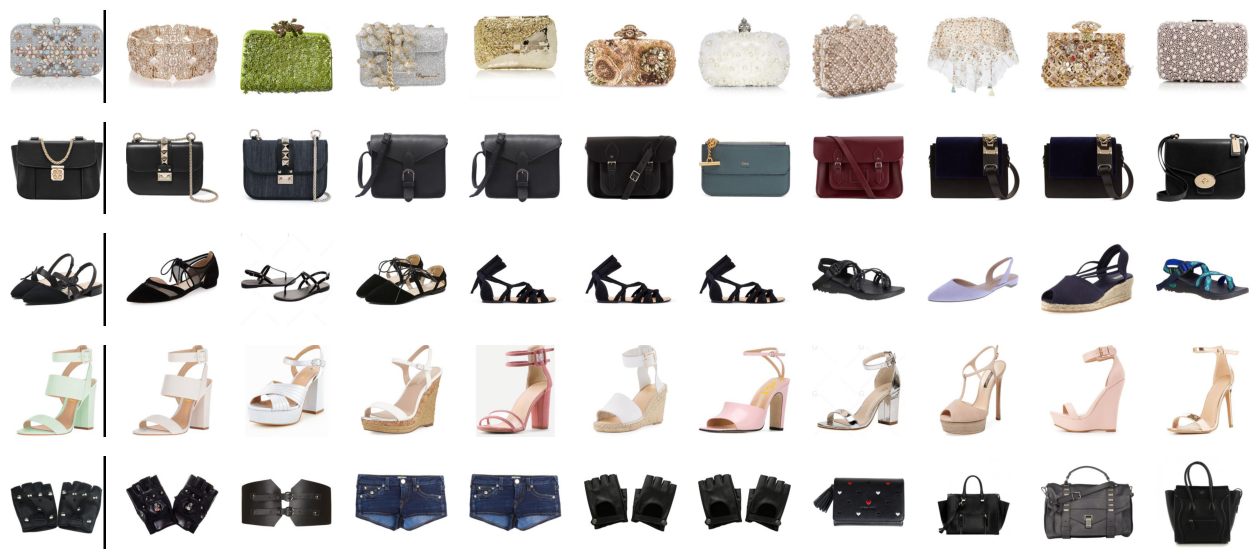

In [97]:
plot_best_10_multiple(index_list, path_list, image_embeddings, cat_list, [0,100,200,300,400])

(<Figure size 1600x700 with 55 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
      

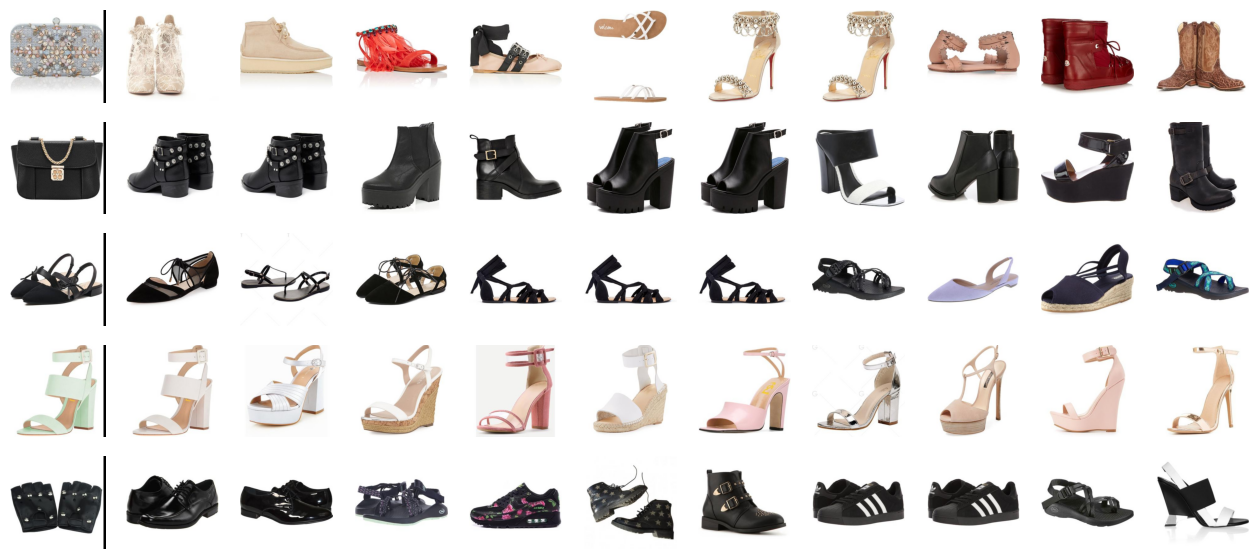

In [98]:
plot_best_10_multiple_category(index_list, path_list, image_embeddings, cat_list, 'shoes', [0,100,200,300,400])

## Materia pasada antes

## 4. Visualización de imágenes y *augmentaciones*

A continuación, como paso intermedio, se visualizan las imágenes y las augmentaciones para alimentar al modelo. Esto se importante puesto que la eficiencia depende del modelo depende directamente de las augmentaciones que se eligan.

In [ ]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

# librerías importantes e importar BYOL
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
from polyvore_dataset_loader import DoubletImageLoader
from torch.nn import MSELoss

from bimodal_byol_shoes.data.custom_transforms import BatchTransform, ListToTensor, PadToSquare, SelectFromTuple, TensorToDevice
from bimodal_byol_shoes.models.BYOL2_model import BYOL2
from sklearn.neighbors import NearestNeighbors
import itertools
import random
import matplotlib.pyplot as plt
from PIL import Image
import time
    
def main():


     # path to important folders
    # path to important folders
    polyvore_dataset = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'polyvore_data')
    polyvore_images = os.path.join(polyvore_dataset, 'images')
    polyvore_info = os.path.join(polyvore_dataset, 'polyvore-info')
    category_info = os.path.join(polyvore_info, 'category_id.txt')
    
    d = {}
    with open(category_info) as f:
        for line in f:
            (key, val) = line.split(' ', 1)
            d[int(key)] = val
            
    category_data = open(category_info, 'r')
    
     # asegurarse que la carpeta exista
    models_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'fashion_models', 'checkpoint_models')

    # revisa si hay gpu cuda sino ocupa cpu
    no_cuda = False # cambiar si se quiere ocupar  cuda
    cuda = not no_cuda and torch.cuda.is_available()   # CAMBIAR SI SE POSEEN RECURSOS COMO GPU
    device = torch.device("cuda" if cuda else "cpu")

    log_interval = 10
    text_feature_dim = 6000
    kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}

    # pre-cargar modelos y evaluar en dataset de validacion o testeo
    val_arg = False
    test_arg = True
    resume = os.path.join(models_folder, 'model_best.pth.tar')

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

    transforms_1 = transforms.Compose([SelectFromTuple(0), TensorToDevice(device)])
    transforms_2 = transforms.Compose([SelectFromTuple(1), TensorToDevice(device)])

    # otros modelos importantes, codificador, se inicializa el modelo
    encoder = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    #encoder.load_state_dict(torch.load('../checkpoints/resnet50_byol_quickdraw_128_1000_v3.pt'))
    empty_transform = transforms.Compose([])
    epochs = 1
    epoch_size = 300
    byol_learner = BYOL2(
        encoder,
        image_size=224,
        hidden_layer='avgpool',
        augment_fn=empty_transform,
        cosine_ema_steps=epochs*epoch_size
    )



    byol_learner.augment1 = transforms_1
    byol_learner.augment2 = transforms_2

    # data parallel
    if cuda:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        byol_learner = nn.DistributedDataParallel(byol_learner)
    byol_learner.to(device)



    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)

            start_epoch = checkpoint['epoch']
            best_val_loss = checkpoint['best_prec1']
            byol_learner.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))


    # augmentación to apply
    augmentation = transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.RandomHorizontalFlip(),
                           normalize])



    # otros modelos importantes, codificador, se inicializa el modelo
    encoder = models.resnet50(weights='DEFAULT')

    # dataloader for the validation data
    val_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('test', polyvore_images, polyvore_info, transform=transforms.ToTensor()),
        batch_size=1, shuffle=True)
    
    
    ## COMENTAR DESPUES
    # dataloaders for training and validation da
    train_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('train', polyvore_images, polyvore_info,
                           transform=transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               normalize,
                           ]), return_image_path=True),
        batch_size=1, shuffle=True, **kwargs)
    
    # get random image from the batch
    for batch_idx, image_info in enumerate(train_loader):
        img1, img1category, anchor_im, img2, img2category, pos_im, img3, img3category, neg_im = image_info
    ## HASTA ACA

    # get random image from the batch
    sample_tensor = None
    sample_category = None
    for batch_idx, image_info in enumerate(val_loader):
        sample_tensor, sample_category = image_info
        break

    # preprocess the tensor and augment it
    sample_tensor = sample_tensor.squeeze()
    augmentated_tensor = augmentation(sample_tensor)

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    sample_image = np.transpose(sample_tensor, (1, 2, 0))
    augmentated_image = np.transpose(augmentated_tensor, (1, 2, 0))
    
    image_cat = d[int(sample_category[0])]
    
    
    # crear figura y subplots
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(sample_image, interpolation='nearest')
    ax[0].set_title('Imagen original', fontweight ="bold")
    ax[0].axis('off')


    ax[1].imshow(augmentated_image, interpolation='nearest')
    ax[1].set_title('Imagen Augmentada', fontweight ="bold")
    ax[1].axis('off')

    # titulo de la figura
    fig.suptitle('Muestra de augmentación de imágen. Categoria {}'.format(image_cat), fontsize=16)


if __name__ == '__main__':
    main() 